# Desafio: Regressão Aplicada à Engenharia de Materiais

@author: Guilherme Nogueira

## Importações

In [ ]:
# Gerais
import numpy as np
import pandas as pd
from datetime import date

# Gráficos
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

# from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance, kelbow_visualizer, silhouette_visualizer

# Machine learning #
from sklearn import datasets
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans, DBSCAN, MeanShift
from sklearn.cluster import k_means, dbscan, mean_shift, estimate_bandwidth
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

from kmodes.kmodes import KModes            # clustering categorical data
from kmodes.kprototypes import KPrototypes  # clustering mixed data

# Didatic purposes
import string
from ipywidgets import interact

## Etapa 01) Análise exploratória dos dados

### a) Carregue a base de dados

In [2]:
df = pd.read_csv("../data/data.csv", encoding="ISO-8859-1")

In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


### b) Realize uma descrição estatística dos dados

- InvoiceDate está como string e precisará ser convertida para datetime;
- CustomerID é numérico, mas representa identificador, não uma grandeza quantitativa;
- StockCode e InvoiceNo também são identificadores categóricos;
- Quantity e UnitPrice são variáveis numéricas relevantes para análise de valor.

In [4]:
df.shape

(541909, 8)

In [5]:
# Tipos das variáveis

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [6]:
# Estatística descritiva

df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


### c) Visualização das distribuições e relevância das colunas

- Os histogramas das variáveis Quantity e UnitPrice evidenciam distribuições fortemente assimétricas, com elevada concentração de observações em valores baixos e presença de caudas longas, característica típica de dados transacionais de e-commerce.

- Na distribuição original, observa-se a influência significativa de valores extremos, incluindo quantidades negativas e preços muito elevados, os quais comprimem a visualização da maior parte das observações. Ao restringir a análise ao intervalo entre os percentis 1% e 99%, torna-se claro que a maioria das transações envolve pequenas quantidades de itens e preços unitários baixos, enquanto compras de grande volume ou alto valor são menos frequentes e podem ser tratadas como outliers nas etapas seguintes.

- Esses resultados indicam a necessidade de tratamento de outliers e de possíveis transformações (como escalonamento robusto ou transformação logarítmica) antes da aplicação de modelos de clusterização, a fim de evitar distorções no agrupamento dos clientes.

Quanto à relevância das colunas para a análise RFV, destaca-se que:
- InvoiceDate é essencial para o cálculo da Recency;
- InvoiceNo permite mensurar a Frequency das compras;
- Quantity e UnitPrice são fundamentais para o cálculo do Valor Monetário (Monetary);
- CustomerID atua como chave de agregação dos dados em nível de cliente;
- StockCode, Description e Country não são diretamente utilizadas no RFV, embora possam apoiar análises complementares e segmentações adicionais.

- Em síntese, as visualizações confirmam que as variáveis centrais para o modelo RFV apresentam comportamento heterogêneo e presença de outliers, reforçando a importância de um pré-processamento adequado antes da modelagem.

In [7]:
# Garantir tipos corretos para análise
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"], errors="coerce")
df["CustomerID"] = df["CustomerID"].astype("Int64").astype(str)  # ID como categórico (não grandeza)

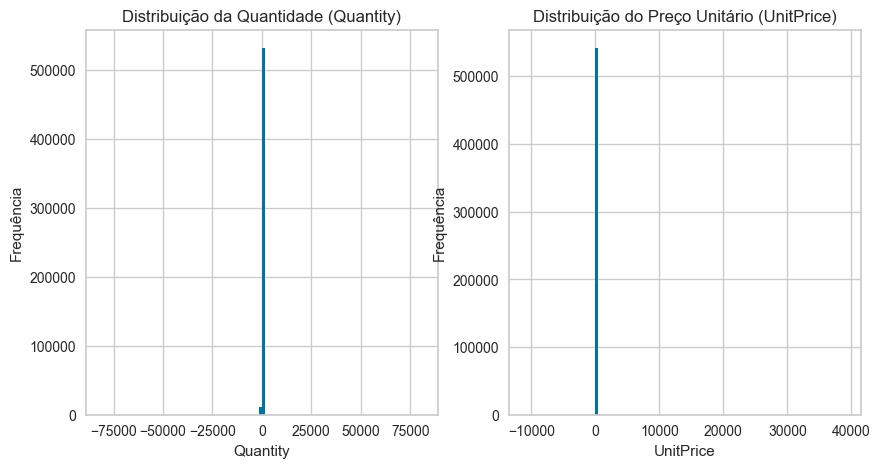

In [8]:
# 1) Distribuições das variáveis numéricas principais
fig, ax = plt.subplots(1, 2, figsize=(10,5))

ax[0].hist(df["Quantity"].dropna(), bins=100)
ax[0].set_title("Distribuição da Quantidade (Quantity)")
ax[0].set_xlabel("Quantity")
ax[0].set_ylabel("Frequência")

ax[1].hist(df["UnitPrice"].dropna(), bins=100)
ax[1].set_title("Distribuição do Preço Unitário (UnitPrice)")
ax[1].set_xlabel("UnitPrice")
ax[1].set_ylabel("Frequência")

plt.show()

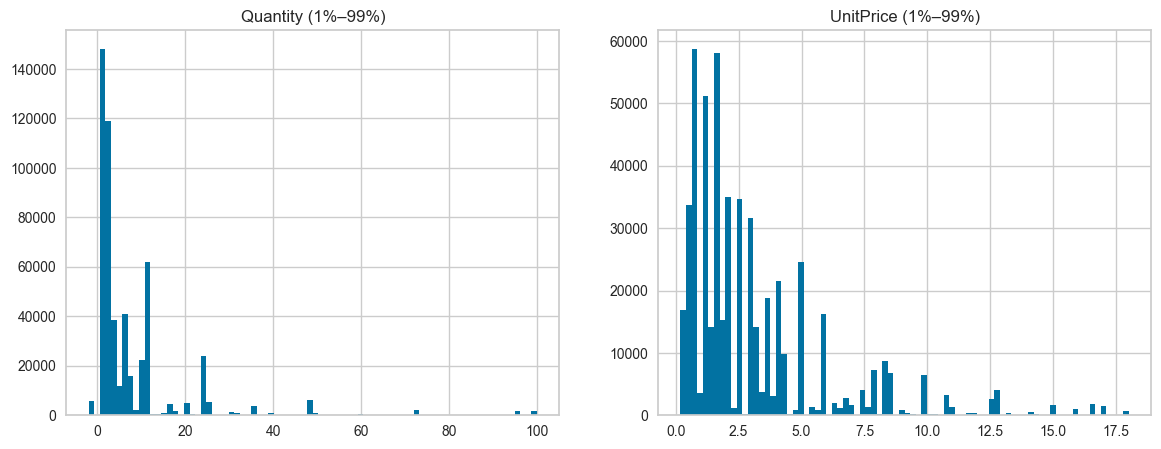

In [9]:
# 2) Visão mais clara com limites por percentis (reduz efeito de outliers no gráfico)
q_lo, q_hi = df["Quantity"].quantile([0.01, 0.99])
p_lo, p_hi = df["UnitPrice"].quantile([0.01, 0.99])

fig, ax = plt.subplots(1, 2, figsize=(14,5))

ax[0].hist(df.loc[df["Quantity"].between(q_lo, q_hi), "Quantity"], bins=80)
ax[0].set_title("Quantity (1%–99%)")

ax[1].hist(df.loc[df["UnitPrice"].between(p_lo, p_hi), "UnitPrice"], bins=80)
ax[1].set_title("UnitPrice (1%–99%)")

plt.show()

In [10]:
# 3) Relevância das colunas para RFV (tabela rápida)
relevancia = pd.DataFrame({
    "Coluna": df.columns,
    "Papel_na_Analise": [
        "Frequency (ID da transação)",
        "Produto (não entra no RFV)",
        "Produto (não entra no RFV)",
        "Monetary (com UnitPrice)",
        "Recency (data/tempo)",
        "Monetary (com Quantity)",
        "Chave do cliente (agregação)",
        "Segmentação extra (país)"
    ]
})

print(relevancia)

        Coluna              Papel_na_Analise
0    InvoiceNo   Frequency (ID da transação)
1    StockCode    Produto (não entra no RFV)
2  Description    Produto (não entra no RFV)
3     Quantity      Monetary (com UnitPrice)
4  InvoiceDate          Recency (data/tempo)
5    UnitPrice       Monetary (com Quantity)
6   CustomerID  Chave do cliente (agregação)
7      Country      Segmentação extra (país)


### d) Verifique a presença de dados nulos, duplicados, outliers e demais inconsistências nos dados.

#### Valores nulos

- A verificação de inconsistências nos dados revelou a presença de 135.080 registros com valores nulos em CustomerID, os quais não poderão ser utilizados nas análises RFV por impossibilitarem a identificação do cliente, além de 1.454 valores ausentes em Description, variável que não compromete a análise principal.
- As demais colunas não apresentam valores nulos, indicando boa integridade estrutural do conjunto de dados.

In [11]:
df.isnull().sum().sort_values(ascending=False)


Description    1454
InvoiceNo         0
StockCode         0
Quantity          0
InvoiceDate       0
UnitPrice         0
CustomerID        0
Country           0
dtype: int64

#### Registros duplicados

- A verificação de registros duplicados revelou a existência de 5.268 observações duplicadas no conjunto de dados. A presença desses registros pode gerar superestimação de frequências de compra e valores monetários, comprometendo a correta mensuração do comportamento dos clientes. Dessa forma, a remoção de duplicatas é necessária para garantir a integridade das análises subsequentes, especialmente no cálculo das métricas RFV e na aplicação dos modelos de segmentação.

In [12]:
df.duplicated().sum()

5268

#### Outliers

- Os boxplots das variáveis Quantity e UnitPrice, construídos a partir do conjunto de dados original, evidenciam a presença de outliers extremos em ambas as distribuições. 
- Em Quantity, observa-se uma grande concentração de valores próximos a zero, acompanhada por observações muito distantes da mediana tanto no sentido positivo quanto no negativo, indicando a existência de compras em volumes extremamente elevados e registros associados a devoluções ou cancelamentos. 
- De forma análoga, a variável UnitPrice apresenta forte assimetria à direita, com diversos valores muito superiores ao intervalo interquartil, representando produtos de alto valor unitário ou possíveis inconsistências de registro.

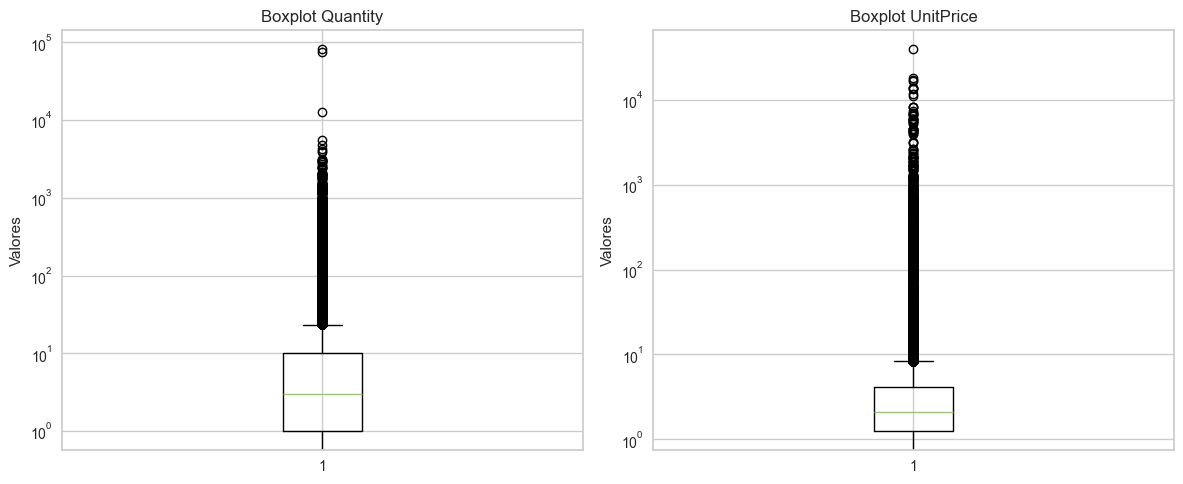

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(12,5))

# Boxplot Quantity
ax[0].boxplot(df['Quantity'])
ax[0].set_yscale('log')
ax[0].set_title('Boxplot Quantity')
ax[0].set_ylabel('Valores')

# Boxplot UnitPrice
ax[1].boxplot(df['UnitPrice'])
ax[1].set_yscale('log')
ax[1].set_title('Boxplot UnitPrice')
ax[1].set_ylabel('Valores')

plt.tight_layout()
plt.show()

##### Outliers em Quantity

- A identificação de outliers na variável Quantity foi realizada por meio do método do Intervalo Interquartil (IQR)
- Aplicando esse critério à base original, foram identificados 58.619 registros classificados como outliers, o que corresponde a aproximadamente 11% do total de observações.

In [14]:
Q1_q = df['Quantity'].quantile(0.25)
Q3_q = df['Quantity'].quantile(0.75)
IQR_q = Q3_q - Q1_q

df_out = df[((df['Quantity'] < (Q1_q - 1.5 * IQR_q)) | (df['Quantity'] > (Q3_q + 1.5 * IQR_q)))]

print(f"Quantidade de registros na base: {len(df)}")
print(f"Quantidade de outliers na base: {len(df_out)}")
print(f"Percentual de outliers: {np.round(100*len(df_out)/len(df), 0)} %")

Quantidade de registros na base: 541909
Quantidade de outliers na base: 58619
Percentual de outliers: 11.0 %


In [15]:
df_sem_out = df[~((df['Quantity'] < (Q1_q - 1.5 * IQR_q)) | (df['Quantity'] > (Q3_q + 1.5 * IQR_q)))]

##### Outliers em UnitPrice

- Após a remoção dos outliers identificados na variável Quantity, a detecção de valores atípicos em UnitPrice foi realizada utilizando o método do Intervalo Interquartil (IQR). 
- Com base nesse critério, foram identificados 32.470 registros classificados como outliers, representando aproximadamente 7% da base remanescente, composta por 483.290 observações.

In [16]:
Q1_u = df['UnitPrice'].quantile(0.25)
Q3_u = df['UnitPrice'].quantile(0.75)
IQR_u = Q3_u - Q1_u

df_out = df[((df['UnitPrice'] < (Q1_u - 1.5 * IQR_u)) | (df['UnitPrice'] > (Q3_u + 1.5 * IQR_u)))]

print(f"Quantidade de registros na base: {len(df)}")
print(f"Quantidade de outliers na base: {len(df_out)}")
print(f"Percentual de outliers: {np.round(100*len(df_out)/len(df), 0)} %")

Quantidade de registros na base: 541909
Quantidade de outliers na base: 39627
Percentual de outliers: 7.0 %


In [17]:
df_final = df_sem_out[~((df_sem_out['Quantity'] < (Q1_u - 1.5 * IQR_u)) | (df_sem_out['Quantity'] > (Q3_u + 1.5 * IQR_u)))]

##### Boxplot após remoção dos outliers

- Os boxplots apresentados refletem o comportamento das variáveis Quantity e UnitPrice após a remoção dos outliers identificados pelo método do intervalo interquartil (IQR). Para Quantity, observa-se uma distribuição mais concentrada em torno da mediana, indicando que a maior parte das transações envolve pequenas quantidades de produtos, com variabilidade reduzida e ausência de valores extremos que possam distorcer a análise.

- No caso de UnitPrice, a utilização de escala logarítmica evidencia de forma mais clara a assimetria da distribuição, característica comum em dados de e-commerce. Ainda que existam valores mais elevados, a dispersão encontra-se substancialmente menor em comparação ao conjunto original, permitindo uma visualização mais fiel do comportamento típico dos preços praticados.

- De maneira geral, os gráficos confirmam que o tratamento dos outliers resultou em um conjunto de dados mais estável e representativo, adequado para o cálculo das métricas RFV e para a aplicação de modelos de clusterização nas etapas subsequentes.

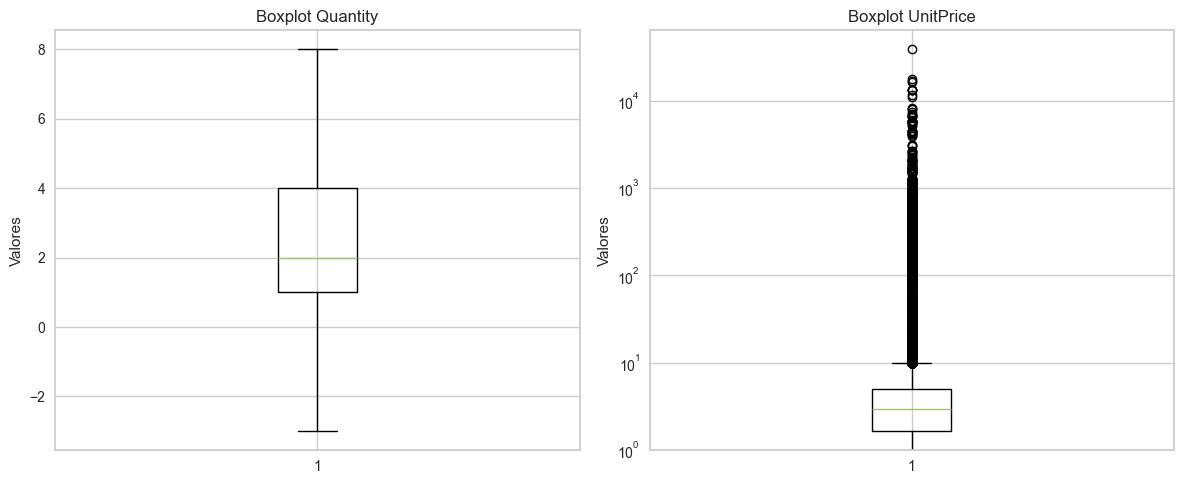

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(12,5))

# Boxplot Quantity
ax[0].boxplot(df_final['Quantity'])
ax[0].set_title('Boxplot Quantity')
ax[0].set_ylabel('Valores')

# Boxplot UnitPrice
ax[1].set_yscale('log')
ax[1].boxplot(df_final['UnitPrice'])
ax[1].set_title('Boxplot UnitPrice')
ax[1].set_ylabel('Valores')

plt.tight_layout()
plt.show()

#### Inconsistências nos dados

- A análise de inconsistências nos dados transacionais evidencia a presença de 10.624 registros com quantidades menores ou iguais a zero, os quais estão associados, em sua maioria, a cancelamentos ou devoluções, não representando consumo efetivo. 
- Adicionalmente, foram identificados 2.517 registros com preços unitários menores ou iguais a zero, caracterizando valores inválidos que comprometem o cálculo correto do valor monetário das transações. 
- Observa-se também a existência de 9.288 transações canceladas, identificadas por números de fatura (InvoiceNo) iniciados com o caractere “C”. 
- Esses registros não refletem o comportamento real de compra dos clientes e, portanto, devem ser excluídos antes do cálculo das métricas RFV, a fim de garantir a consistência e a confiabilidade das análises subsequentes.

In [19]:
# Quantidades negativas ou zero
# Indicam cancelamentos ou devoluções, que devem ser removidos antes do cálculo RFV

(df["Quantity"] <= 0).sum()

10624

In [20]:
# Preços inválidos

(df["UnitPrice"] <= 0).sum()

2517

In [21]:
# Transações canceladas (InvoiceNo iniciando com "C")
# Essas transações não representam consumo efetivo e devem ser excluídas em etapas posteriores.

df["InvoiceNo"] = df["InvoiceNo"].astype(str)
df["InvoiceNo"].str.startswith("C").sum()

9288

## Etapa 02) Pré-processamento dos dados

### a) Realize a normalização dos dados

In [22]:
from sklearn.preprocessing import RobustScaler

# Seleção das variáveis numéricas
df_norm = df_final.copy()

# Normalização
scaler = RobustScaler()
df_norm[["Quantity", "UnitPrice"]] = scaler.fit_transform(
    df_norm[["Quantity", "UnitPrice"]]
)

df_norm.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,1.333333,2010-12-01 08:26:00,-0.120482,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,1.333333,2010-12-01 08:26:00,0.132530,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,2.000000,2010-12-01 08:26:00,-0.060241,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,1.333333,2010-12-01 08:26:00,0.132530,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,1.333333,2010-12-01 08:26:00,0.132530,17850,United Kingdom


### b) Faça uma seleção das variáveis mais relevantes para o modelo

- Para a modelagem baseada em comportamento de compra, são mantidas apenas as variáveis essenciais à análise, descartando atributos que não contribuem diretamente para a construção das métricas RFVFV ou para a clusterização.
- As variáveis StockCode, Description e Country não são utilizadas neste momento, pois não contribuem diretamente para a análise quantitativa do comportamento de compra dos clientes.

In [23]:
df_model = df_norm[[
    "CustomerID",
    "InvoiceNo",
    "InvoiceDate",
    "Quantity",
    "UnitPrice"
]].copy()

In [24]:
df_model.head()

,CustomerID,InvoiceNo,InvoiceDate,Quantity,UnitPrice
0,17850,536365,2010-12-01 08:26:00,1.333333,-0.120482
1,17850,536365,2010-12-01 08:26:00,1.333333,0.132530
2,17850,536365,2010-12-01 08:26:00,2.000000,-0.060241
3,17850,536365,2010-12-01 08:26:00,1.333333,0.132530
4,17850,536365,2010-12-01 08:26:00,1.333333,0.132530


### c) Remova os dados nulos, duplicados, outliers e inconsistentes

In [25]:
# Remoção de registros sem identificação do cliente
df_model = df_model.dropna(subset=["CustomerID"])

# Remoção de registros duplicados
df_model = df_model.drop_duplicates()

# Remoção de transações canceladas
df_model["InvoiceNo"] = df_model["InvoiceNo"].astype(str)
df_model = df_model[~df_model["InvoiceNo"].str.startswith("C")]

# Remoção de valores inválidos
df_model = df_model[(df_model["Quantity"] > 0) & (df_model["UnitPrice"] > 0)]

In [26]:
print(f"Tamanho inicial da base: {df.shape}")
print(f"Tamanho final da base: {df_model.shape}")

Tamanho inicial da base: (541909, 8)
Tamanho final da base: (39258, 5)


## Etapa 03) Selecione um algoritmo de clusterização

### a) Escolha um algoritmo adequado para base de dados, como o K0Means, DBSCAN, Hierarquia ou Mean Shift

In [ ]:
"""
Seguindo o material de aula, o algoritmo escolhido foi o K-Means, por apresentar:
- boa performance computacional em bases grandes;
- funcionamento adequado para variáveis numéricas normalizadas;
- ampla utilização em problemas de segmentação;
- métricas de avaliação bem definidas (WCSS, Silhouette, Davies-Bouldin, Calinski-Harabasz).

Assim como nos exemplos apresentados em aula, a clusterização será realizada utilizando a implementação do KMeans do scikit-learn.
"""

'\nO algoritmo escolhido foi o K-Means, por apresentar as seguintes vantagens neste contexto:\n- É amplamente utilizado em problemas de segmentação de clientes;\n- Apresenta boa eficiência computacional para bases grandes;\n- Funciona adequadamente com variáveis numéricas previamente normalizadas;\n- Produz clusters facilmente interpretáveis do ponto de vista gerencial.\n- Assim, o K-Means se mostra apropriado para agrupar observações com base em similaridade de comportamento de compra.\n'

In [43]:
# Dados para clusterização (já limpos e tratados)

X = df_model[["Quantity", "UnitPrice"]].values

### b) Encontre a quantidade ideal de clusters através dos métodos de Elbow ou Silhouette Score

k = 2 maximiza a qualidade matemática, mas gera uma segmentação excessivamente grosseira.

k ≥ 6 aumenta a complexidade sem ganhos relevantes de Silhouette.

k = 3 apresenta:
- Silhouette ainda alto (0.63);
- Davies–Bouldin baixo;
- Redução expressiva da inertia;
- Maior interpretabilidade prática, critério explícito no material do professor.

In [44]:
# Avaliação para diferentes valores de k

cluster_metrics = silhouette_score, davies_bouldin_score, calinski_harabasz_score
cluster_metrics_results = []

for k in range(2, 11):
    model = KMeans(n_clusters=k, random_state=0)
    labels = model.fit_predict(X)
    
    results = {
        "k": k,
        "inertia": model.inertia_
    }
    
    for metric in cluster_metrics:
        results[metric.__name__] = metric(X, labels)
        
    cluster_metrics_results.append(results)

cluster_metrics_df = pd.DataFrame(cluster_metrics_results).set_index("k")

In [51]:
print(cluster_metrics_df)

         inertia  silhouette_score  davies_bouldin_score  \
k                                                          
2   32292.687391          0.691169              0.630076   
3   23520.589864          0.630658              0.603644   
4   16390.274543          0.494893              0.717821   
5   12037.938568          0.535497              0.677735   
6    8703.999632          0.536249              0.604603   
7    7573.384725          0.535860              0.626671   
8    6593.344800          0.537552              0.601598   
9    5798.885605          0.532197              0.594399   
10   4724.269945          0.469653              0.648169   

    calinski_harabasz_score  
k                            
2              31881.627566  
3              29205.600337  
4              33632.226828  
5              37891.130581  
6              44929.728433  
7              44006.515844  
8              44158.928057  
9              44603.722487  
10             49715.811531  


In [46]:
# Visualização formatada

(cluster_metrics_df.style
    .background_gradient(cmap="Oranges", subset="inertia")
    .highlight_max(subset=["silhouette_score", "calinski_harabasz_score"])
    .highlight_min(subset="davies_bouldin_score")
)

,inertia,silhouette_score,davies_bouldin_score,calinski_harabasz_score
k,,,,
2,32292.687391,0.691169,0.630076,31881.627566
3,23520.589864,0.630658,0.603644,29205.600337
4,16390.274543,0.494893,0.717821,33632.226828
5,12037.938568,0.535497,0.677735,37891.130581
6,8703.999632,0.536249,0.604603,44929.728433
7,7573.384725,0.535860,0.626671,44006.515844
8,6593.344800,0.537552,0.601598,44158.928057
9,5798.885605,0.532197,0.594399,44603.722487
10,4724.269945,0.469653,0.648169,49715.811531


### c) Implemente o algoritmo escolhido

Adota-se k = 3 como número ideal de clusters, pois representa o melhor compromisso entre qualidade estatística (Silhouette e Davies–Bouldin), redução da variabilidade intra-cluster (inertia) e capacidade de interpretação dos grupos formados, evitando tanto a superagregação (k = 2) quanto a fragmentação excessiva (k ≥ 6).

O gráfico de dispersão apresenta os clusters gerados pelo algoritmo K-Means com k = 3, considerando as variáveis Quantity e UnitPrice, sendo esta última representada em escala logarítmica para melhor visualização da assimetria dos preços.

Observa-se que a separação entre os clusters ocorre predominantemente ao longo do eixo de UnitPrice, indicando que o preço unitário é o principal fator discriminante entre os grupos, enquanto a variável Quantity apresenta menor variabilidade e, consequentemente, menor poder de separação neste conjunto de dados após o tratamento dos outliers.

Descrição dos clusters
- Cluster 0 (verde): Concentra transações com preços unitários baixos, representando compras de menor valor monetário. Esse grupo corresponde ao comportamento mais frequente na base de dados, característico de itens de baixo custo adquiridos em pequenas quantidades.
- Cluster 1 (laranja): Agrupa transações com preços unitários elevados, mesmo quando a quantidade comprada é pequena. Esse cluster representa compras de maior valor agregado, possivelmente associadas a produtos premium ou de maior ticket unitário.
- Cluster 2 (azul): Apresenta valores intermediários de preço unitário, posicionando-se entre os clusters 0 e 1. Esse grupo pode ser interpretado como um segmento de valor médio, com padrão de compra intermediário.

In [52]:
k_optimal = 3

model = KMeans(n_clusters=k_optimal, random_state=0)
labels = model.fit_predict(X)

df_model["Cluster"] = labels

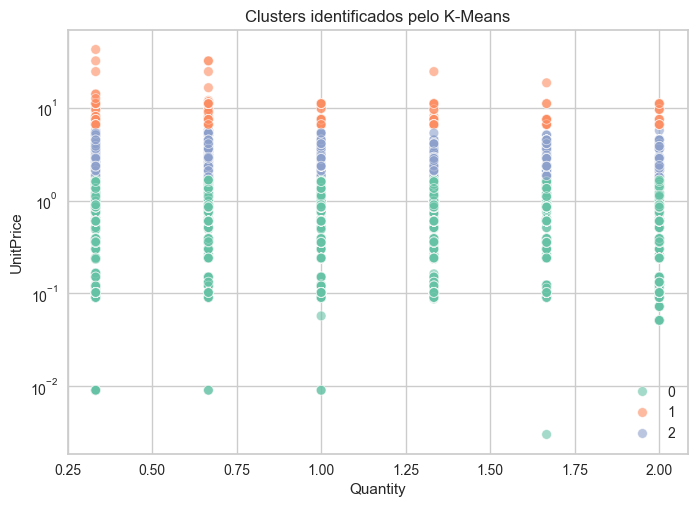

In [53]:
# Visualização dos clusters

sns.scatterplot(x=X[:,0], y=X[:,1], hue=labels, palette="Set2", alpha=0.6)

plt.yscale("log")  # devido à assimetria de UnitPrice
plt.xlabel("Quantity")
plt.ylabel("UnitPrice")
plt.title("Clusters identificados pelo K-Means")
plt.show()

## Etapa 04) Analise os clusters obtidos

### a) Identifique os padrões e características em comum entre os clientes

A análise dos clusters gerados pelo algoritmo K-Means evidencia que a segmentação ocorreu predominantemente com base no valor monetário das transações, sendo a variável UnitPrice o principal fator discriminante entre os grupos. A variável Quantity, após o tratamento dos outliers, apresenta menor variabilidade e exerce papel secundário na separação dos clusters.

De forma geral, os clusters podem ser caracterizados da seguinte maneira:
- Cluster 0 – Baixo valor monetário: Este cluster concentra transações com preços unitários baixos, representando o comportamento mais frequente na base. Os clientes associados a esse grupo tendem a realizar compras de baixo ticket, geralmente de produtos mais acessíveis, em pequenas quantidades. Trata-se do segmento de maior volume, porém com menor valor agregado por transação.

- Cluster 1 – Alto valor monetário: Agrupa transações com preços unitários elevados, mesmo quando a quantidade adquirida é reduzida. Esse cluster representa clientes com comportamento de compra voltado a produtos de maior valor agregado, caracterizando um segmento potencialmente mais lucrativo, apesar de menos numeroso.

- Cluster 2 – Valor monetário intermediário: Apresenta características intermediárias entre os clusters 0 e 1, reunindo transações com preços unitários médios. Esse grupo pode ser interpretado como um segmento de clientes de valor médio, que não se enquadram nem no padrão de baixo custo nem no de alto ticket.

Em síntese, os clusters refletem diferentes perfis de valor de compra, permitindo à empresa identificar segmentos com comportamentos distintos e potencial para estratégias de marketing diferenciadas.

### b) Plote gráficos para auxiliar na análise

#### Dispersão Quantity × UnitPrice por cluster

O gráfico de dispersão evidencia que a separação entre os clusters ocorre predominantemente ao longo do eixo de UnitPrice, especialmente quando observada em escala logarítmica. A variável Quantity apresenta comportamento bastante semelhante entre os grupos, com concentrações próximas e pouca variabilidade relativa, indicando baixo poder discriminante. Dessa forma, o algoritmo K-Means segmentou as observações essencialmente com base no nível de preço unitário, distinguindo transações de baixo, médio e alto valor monetário.

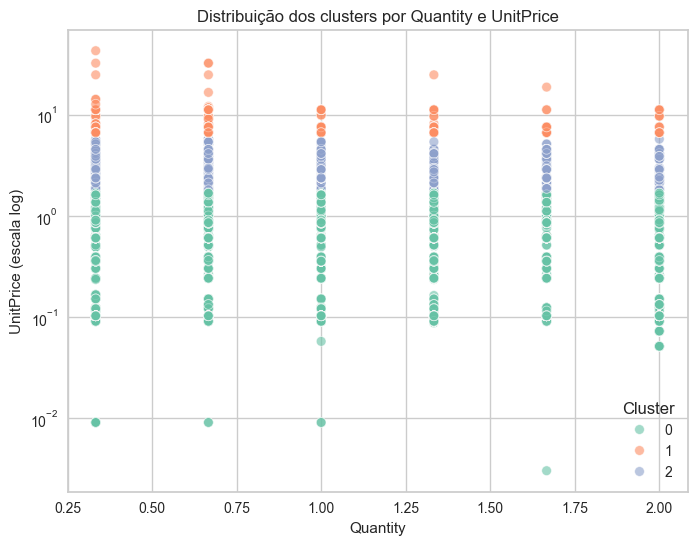

In [55]:
# Dispersão Quantity × UnitPrice por cluster

plt.figure(figsize=(8,6))
sns.scatterplot(data=df_model, x="Quantity", y="UnitPrice", hue="Cluster", palette="Set2", alpha=0.6)
plt.yscale("log")
plt.title("Distribuição dos clusters por Quantity e UnitPrice")
plt.xlabel("Quantity")
plt.ylabel("UnitPrice (escala log)")
plt.show()

#### Boxplot de UnitPrice por cluster

O boxplot do UnitPrice confirma uma clara diferenciação monetária entre os clusters. O Cluster 0 concentra os menores preços unitários, com mediana em torno de valores baixos e maior dispersão relativa, caracterizando compras de baixo ticket. O Cluster 1 apresenta os maiores valores de UnitPrice, com mediana elevada e maior variabilidade, indicando transações de alto valor agregado. Já o Cluster 2 ocupa uma posição intermediária, com preços unitários médios e menor dispersão, representando um segmento de valor moderado.

C:\Users\Guilherme\AppData\Local\Temp\ipykernel_12672\148874894.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot( data=df_model, x="Cluster", y="UnitPrice", palette="Set2" )


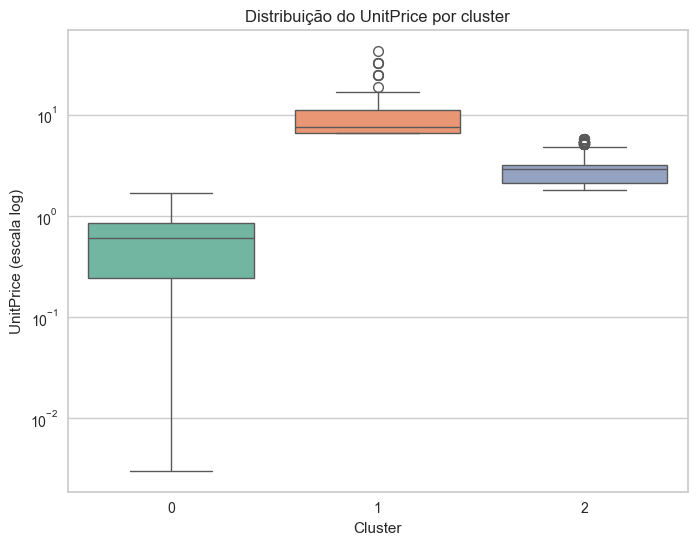

In [56]:
# Boxplot de UnitPrice por cluster

plt.figure(figsize=(8,6))
sns.boxplot( data=df_model, x="Cluster", y="UnitPrice", palette="Set2" )
plt.yscale("log")
plt.title("Distribuição do UnitPrice por cluster")
plt.xlabel("Cluster")
plt.ylabel("UnitPrice (escala log)")
plt.show()

#### Boxplot de Quantity por cluster

A análise da Quantity por cluster revela distribuições muito semelhantes entre os grupos, com medianas praticamente idênticas e intervalos interquartis sobrepostos. Isso indica que a quantidade comprada não é um fator relevante para a separação dos clusters neste conjunto de dados após o tratamento dos outliers. Assim, a segmentação reflete principalmente diferenças de valor monetário, e não de volume de itens adquiridos.

C:\Users\Guilherme\AppData\Local\Temp\ipykernel_12672\694218866.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot( data=df_model, x="Cluster", y="Quantity", palette="Set2" )


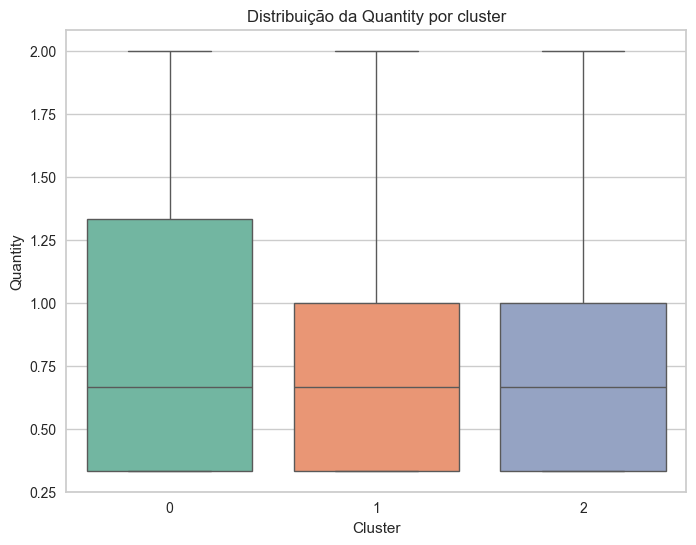

In [57]:
# Boxplot de Quantity por cluster

plt.figure(figsize=(8,6))
sns.boxplot( data=df_model, x="Cluster", y="Quantity", palette="Set2" )
plt.title("Distribuição da Quantity por cluster")
plt.xlabel("Cluster")
plt.ylabel("Quantity")
plt.show()

#### Estatísticas descritivas por cluster (resumo numérico)

As estatísticas descritivas reforçam as evidências gráficas. Em termos de Quantity, os três clusters apresentam médias, medianas e dispersões bastante próximas, confirmando a homogeneidade dessa variável entre os grupos. Em contraste, o UnitPrice exibe diferenças marcantes: o Cluster 0 possui média e mediana baixas, o Cluster 2 apresenta valores intermediários, e o Cluster 1 concentra os maiores preços unitários, com maior desvio-padrão e valores máximos significativamente superiores. Esses resultados corroboram que os clusters identificados representam segmentos distintos de valor de compra, diferenciados principalmente pelo preço unitário dos produtos.

In [58]:
# Estatísticas descritivas por cluster (resumo numérico)

df_model.groupby("Cluster")[["Quantity", "UnitPrice"]].agg(
    ["mean", "median", "std", "min", "max"]
)

Quantity                                    UnitPrice            \
             mean    median       std       min  max      mean    median   
Cluster                                                                    
0        0.856009  0.666667  0.506076  0.333333  2.0  0.601244  0.602410   
1        0.784076  0.666667  0.511987  0.333333  2.0  9.011134  7.545181   
2        0.787362  0.666667  0.493037  0.333333  2.0  2.892990  2.864458   

                                        
              std       min        max  
Cluster                                 
0        0.417683  0.003012   1.671687  
1        4.352662  6.626506  42.786145  
2        0.834472  1.807229   5.722892

## Etapa 05) Interpretação dos resultados obtidos

### a) Descreva o perfil de compras dos clientes de cada cluster

A análise dos clusters permite identificar três perfis distintos de comportamento de compra, diferenciados principalmente pelo valor monetário das transações, enquanto a quantidade adquirida apresenta padrão semelhante entre os grupos.

Cluster 0 – Clientes de baixo valor de compra:
- Este cluster é caracterizado por transações com preços unitários baixos, representando clientes que priorizam produtos de menor custo. Apesar de possuírem comportamento de compra frequente, esses clientes apresentam baixo ticket médio, contribuindo menos para a receita individual da empresa. Esse grupo tende a ser mais sensível a preço e promoções.

Cluster 1 – Clientes de alto valor de compra:
- Os clientes desse cluster realizam compras com preços unitários elevados, mesmo quando a quantidade adquirida é pequena. Trata-se de um segmento com alto valor agregado, potencialmente mais lucrativo, associado à aquisição de produtos premium ou de maior valor percebido. Embora menos numeroso, esse grupo possui grande relevância estratégica para a empresa.

Cluster 2 – Clientes de valor intermediário:
- Este cluster apresenta comportamento de compra intermediário, com preços unitários médios. Esses clientes não se enquadram nem no perfil de baixo custo nem no de alto valor, representando um segmento com potencial de crescimento de ticket médio por meio de estratégias adequadas de incentivo.

### b) Justifique como essa análise pode ser útil para empresa para segmentação de seus clientes e personalização das campanhas de marketing

A segmentação baseada em clusterização permite à empresa compreender melhor a heterogeneidade de sua base de clientes, indo além de análises agregadas que mascaram diferenças relevantes de comportamento. Ao identificar grupos com padrões de compra distintos, a empresa pode personalizar suas campanhas de marketing, direcionando ofertas, comunicações e benefícios de forma mais assertiva.

Além disso, essa abordagem possibilita otimizar a alocação de recursos, concentrando esforços em segmentos estratégicos, como clientes de alto valor, sem negligenciar oportunidades de crescimento em grupos intermediários. A análise também fornece subsídios para decisões relacionadas a precificação, mix de produtos e programas de fidelização, aumentando a eficiência das ações comerciais.

### c) Sugira ações possíveis com base nas ações realizadas

Com base nos perfis identificados, podem ser sugeridas as seguintes ações:

Cluster 0 – Baixo valor
- Campanhas promocionais e descontos direcionados;
- Ofertas de kits ou combos para estimular o aumento do ticket médio;
- Comunicação focada em custo-benefício e preços competitivos.

Cluster 1 – Alto valor
- Programas de fidelização exclusivos e benefícios premium;
- Ofertas personalizadas de produtos de maior valor agregado;
- Comunicação diferenciada, destacando qualidade, exclusividade e experiência de compra.

Cluster 2 – Valor intermediário
- Estratégias de upselling e cross-selling para elevar o valor das compras;
- Recomendações personalizadas com base em histórico de consumo;
- Incentivos graduais para migração ao segmento de maior valor.